# Load dataset

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

#with open('/home/fragaria/ML-Mini-Project/EMNIST/test.tx', 'r') as file:
#    # Read the contents of the file
#    file_contents = file.read()
## Print the contents
#print(file_contents)



In [3]:
import numpy as np
import os
import gzip

# Loads the gzipped binary IDX format using numpy and the gzip library
def load_mnist(path, kind='train'):
    """Load EMNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

# Load dataset
X_train_full, y_train_full = load_mnist('/home/fragaria/ML-Mini-Project/EMNIST/', kind='emnist-balanced-train')
X_test_full, y_test_full = load_mnist('/home/fragaria/ML-Mini-Project/EMNIST/', kind='emnist-balanced-test')

# Print shapes of train & test set
print("X_train_full shape:")
print(X_train_full.shape)
print("y_train_full shape:")
print(y_train_full.shape)

print("X_test_full shape:")
print(X_test_full.shape)
print("y_test_full shape:")
print(y_test_full.shape)

X_train_full shape:
(112800, 784)
y_train_full shape:
(112800,)
X_test_full shape:
(18800, 784)
y_test_full shape:
(18800,)


# Data preparation

In [4]:
# Reshape from a flattened version to 2D form
X_train = X_train_full.reshape((-1, 28, 28))
X_test = X_test_full.reshape((-1, 28, 28))

# Rotate 90 degrees counter clockwise
X_train = np.rot90(X_train, axes=(1, 2), k=-1)
X_test = np.rot90(X_test, axes=(1, 2), k=-1)

# Flip the images along the vertical axis
X_train = np.flip(X_train, axis=2)
X_test = np.flip(X_test, axis=2)

### Scheduled for removal ###
# Take a subset of the training data as validation data
#X_valid, X_train = X_train[:5000], X_train[5000:]
#y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
#############################

# Take a random subset of the training data as validation data
indices = np.random.choice(len(X_train), 5000, replace=False)

X_valid = X_train[indices]
X_train = np.delete(X_train, indices, axis=0)

y_valid = y_train_full[indices]
y_train = np.delete(y_train_full, indices, axis=0)

# Print shapes of train & valid set
print("X_train shape:")
print(X_train.shape)
print("y_train shape:")
print(y_train.shape)

print("X_valid shape:")
print(X_valid.shape)
print("y_valid shape:")
print(y_valid.shape)

X_train shape:
(107800, 28, 28)
y_train shape:
(107800,)
X_valid shape:
(5000, 28, 28)
y_valid shape:
(5000,)


14
E


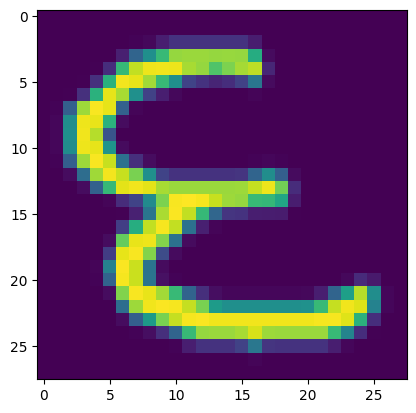

In [5]:
import matplotlib.pyplot as plt

def create_emnist_balanced_mapping():
    mapping = {}

    # Mapping for digits (0-9)
    for i in range(10):
        mapping[i] = chr(i + 48)  # ASCII codes for '0' to '9' are 48 to 57

    # Mapping for uppercase letters (A-Z), excluding some
    for i in range(10, 36):
        mapping[i] = chr(i + 55)  # ASCII codes for 'A' to 'Z' are 65 to 90

    # Custom mapping for lowercase letters
    custom_lower = [97, 98, 100, 101, 102, 103, 104, 110, 113, 114, 116]
    for i, ascii_code in enumerate(custom_lower, start=36):
        mapping[i] = chr(ascii_code)

    return mapping

# Create the mapping
emnist_classes = create_emnist_balanced_mapping()

# Check some data for correct mapping
num = 6
print(y_test_full[num])
plt.imshow(X_test[num])
print(emnist_classes[y_test_full[num]])

# Convolutional model

In [6]:
import sys
if "google.colab" in sys.modules:
  %pip install -q -U keras_tuner

import keras_tuner as kt
import tensorflow as tf

def build_model(hp):
  n_conv_layers = hp.Int("n_conv_layers", min_value=1, max_value=4, default=1)
  n_dense_neurons = hp.Int("n_dense_neurons", min_value=32, max_value=512, step=32)
  n_kernel_size = hp.Int("n_kernel_size", min_value=2, max_value=6, step=2)

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape=(28,28,1)))
  for _ in range(n_conv_layers):
    nks = n_kernel_size
    model.add(tf.keras.layers.Conv2D(kernel_size=(nks,nks), strides=(1,1), filters=32, activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(n_dense_neurons, activation="relu"))
  model.add(tf.keras.layers.Dense(len(emnist_classes), activation="softmax"))

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
  return model

2024-03-20 13:02:28.924772: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 13:02:28.946269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 13:02:29.396613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
bo_tuner = kt.BayesianOptimization(build_model, objective="val_accuracy", max_trials=50, seed=123, directory="ECBT", project_name="emnist_conv_bo_tuner")
bo_tuner.search(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Trial 21 Complete [00h 04m 50s]
val_accuracy: 0.8596000075340271

Best val_accuracy So Far: 0.8673999905586243
Total elapsed time: 16h 11m 50s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_conv_layers
512               |512               |n_dense_neurons
6                 |6                 |n_kernel_size

Epoch 1/20
2107/3369 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3531 - loss: 2.5494

KeyboardInterrupt: 

# Evaluate

In [8]:
best_trial = bo_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 19 summary
Hyperparameters:
n_conv_layers: 4
n_dense_neurons: 512
n_kernel_size: 6
Score: 0.8673999905586243


In [9]:
best_model = bo_tuner.get_best_models()[0]
best_model.evaluate(X_test, y_test_full)

588/588 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8601 - loss: 0.4218


[0.4248819053173065, 0.8600531816482544]

In [10]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = best_model.predict(X_test)
y_test_one_hot = np.eye(len(emnist_classes))[y_test_full]

#print(y_pred)
#print(y_test_one_hot)

mse = mean_squared_error(y_test_one_hot, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_one_hot, y_pred)
print(f'MSE: {mse} | RMSE: {rmse} | MAE: {mae}')

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE: 0.004232548406086955 | RMSE: 0.06505803875069517 | MAE: 0.007374704471398783


## Retrain model for training vs. validation accuracy/loss plot

In [13]:
best_hps = bo_tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])

history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.4678 - loss: 1.9756 - val_accuracy: 0.7692 - val_loss: 0.7075
Epoch 2/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8023 - loss: 0.5982 - val_accuracy: 0.8274 - val_loss: 0.5336
Epoch 3/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8350 - loss: 0.4858 - val_accuracy: 0.8270 - val_loss: 0.4933
Epoch 4/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.8494 - loss: 0.4377 - val_accuracy: 0.8376 - val_loss: 0.4709
Epoch 5/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8596 - loss: 0.3953 - val_accuracy: 0.8376 - val_loss: 0.4619
Epoch 6/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8689 - loss: 0.3722 - val_accuracy: 0.8428 - val_loss: 0.4386
Epoch 7/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8729 - loss: 0.3507 - val_accuracy: 0.8514 - val_loss: 0.4263
Epoch 8/10
6738/6738 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8807 - loss: 0

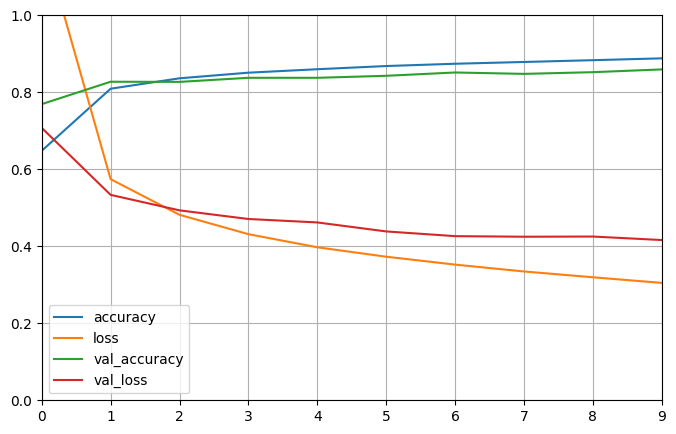

In [15]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_xlim(0, 9)
plt.gca().set_ylim(0, 1)
plt.show()